### Summary
In this notebook, let's explore the effect of display (and street) address to the prediction of interest_level.

In particular, we'll show different feature engineering from the display_address, based on the neat <mark>Random Forest Starter</mark> by Li Li.

In [81]:
# ...let's import the modules
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
# ... and load the training data
df = pd.read_json(open("../../input/train.json", "r"))
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


### Basic feature engineering

In [83]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day"]

### Basic encoding of the "display_address" feature

In [84]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df['display_address'].values))
df['display_address_numeric'] = lbl.transform(list(df['display_address'].values))

# let's add this feature
features_to_use.append('display_address_numeric')

### Explore if certain address affect prediction

In [85]:
# frequency table of address (automatically sorted in descending order)
addr_count = pd.value_counts(df.display_address).reset_index()
addr_count.columns = ['display_address', 'count']
addr_count.head()

,display_address,count
0,Broadway,438
1,East 34th Street,355
2,Second Avenue,349
3,Wall Street,332
4,West 37th Street,287


In [86]:
display_address = df.display_address.copy()
counts = pd.value_counts(display_address)
mask = display_address.isin(counts[:5].index)
display_address[~mask] = 'other'
addr_name = pd.get_dummies(display_address)

for addr in addr_count.iloc[:5,0]:
    df[addr] = addr_name[addr]
    features_to_use.append(addr)
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,num_description_words,created_year,created_month,created_day,display_address_numeric,Broadway,East 34th Street,Second Avenue,Wall Street,West 37th Street
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,95,2016,6,24,6544,0,0,0,0,0
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,9,2016,6,12,4506,0,0,0,0,0
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,94,2016,4,17,7387,0,0,0,0,0


### We split the training data, so to avoid cheeting in the validation phase

In [87]:
# Let's split the data
X = df[features_to_use]
y = df["interest_level"]
np.random.seed(3668)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

### Let's train and validate a few random forest classifiers to see whether we can improve performances with the additional features

### Basic model with no address related features, this is the model in Li Li's Random Forest Starter

In [88]:
# features to use for this classifier == only basic numerical
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['display_address_numeric','Broadway','East 34th Street','Second Avenue', 'Wall Street','West 37th Street']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62888516522015747

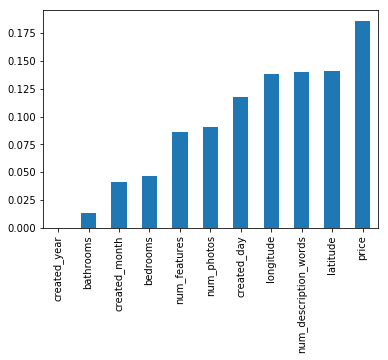

In [89]:
# Let's visualize features importance, 
# price is the most important feature, followed by number of descriptive words, latitude and longitude
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### Now let's add the display_address within the prediction

In [90]:
# display_address added
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['Broadway','East 34th Street','Second Avenue', 'Wall Street','West 37th Street']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62714381076727455

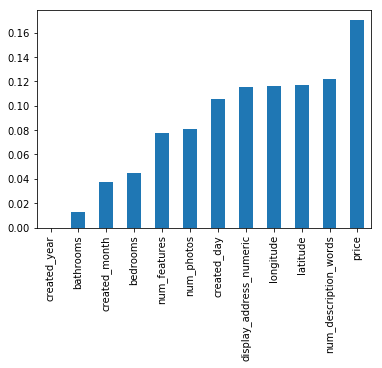

In [91]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### Consider if specific addresses can improve prediction?

In [93]:
# add features such as 'Broadway', 'wall street'
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['display_address_numeric']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.63117705356700526

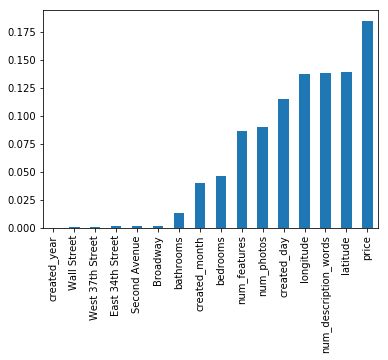

In [94]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### add-on effect of 'display_address' and specific features

In [97]:
# display_address added
np.random.seed(12345)
these_features = [f for f in features_to_use]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62734770271302076

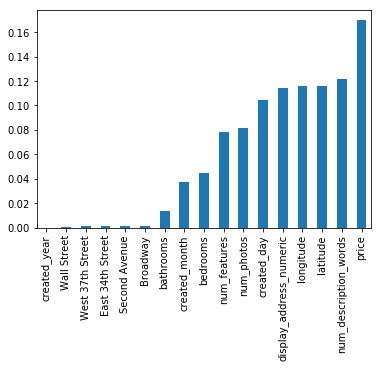

In [98]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()